# US Household displacement in disasters: Exploratory analysis

## General background

In 2022, more than 1.3% of the adult population (3.3M) in the United States was displaced by disasters [(AP News)](https://apnews.com/article/natural-disasters-indiana-florida-climate-and-environment-0bfdab41b233feba55e08382a0594258).

This notebook investigates the public use files (PUF) from the [**United States Household Pulse Survey**](https://www.census.gov/programs-surveys/household-pulse-survey.html). Information regarding displacement following disasters was introduced from Week 52. The availability of microdata allows an exploration of various factors that may be associated longer displacement durations.


## Notebook scope
Tools to visualize data prior to model fitting

## Configuration

* Load dependencies

* Load configuration for figures/plotting

* Load custom methods to process data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from parsers.parse_data_dictionary import parse_data_dictionary
from parsers.parse_puf_files import parse_puf_files, custom_puf_handling
from plotters.plot_crosstab import plot_crosstab
from plotters.plot_correlation import plot_correlation_matx
from plotters.plot_clusters import plot_heirarchical_clusters
from util.plot import plot_config
from util.data import create_crosstab, create_correlation_matx

plot_config()

## Read and parse data

* Read a data dictionary (`data_dict`), which helps parse the variables available in the PUF and provides human-friendly string descriptions

* Read multiple PUF files and combine into one DataFrame (`puf`)

* Displace the overall displacement rate based on the data (with household weights applied)

In [2]:
# Read data dictionary
data_folder = os.path.join("data")
data_dict_path = os.path.join(data_folder, "Data_Dictionary.xlsx")
data_dict = parse_data_dictionary(data_dict_path).set_index('Variable')

# Print available factors
print(f"Potentially relevant factors for processing: {data_dict.index.values}")

# Preview
data_dict.head(5)

Potentially relevant factors for processing: ['TBIRTH_YEAR' 'RHISPANIC' 'RRACE' 'EEDUC' 'MS' 'GENID_DESCRIBE'
 'THHLD_NUMPER' 'THHLD_NUMKID' 'THHLD_NUMADLT' 'KIDS_LT5Y' 'KIDS_5_11Y'
 'KIDS_12_17Y' 'TENROLLPUB' 'TENROLLPRV' 'TENROLLHMSCH' 'ANYWORK'
 'KINDWORK' 'SETTING' 'TWDAYS' 'FRMLA_YN' 'ND_DISPLACE' 'ND_TYPE1'
 'ND_TYPE2' 'ND_TYPE3' 'ND_TYPE4' 'ND_TYPE5' 'ND_HOWLONG' 'ND_DAMAGE'
 'ND_FDSHRTAGE' 'ND_WATER' 'ND_ELCTRC' 'ND_UNSANITARY' 'ANXIOUS' 'WORRY'
 'INTEREST' 'DOWN' 'SEEING' 'HEARING' 'REMEMBERING' 'MOBILITY' 'SELFCARE'
 'UNDERSTAND' 'TENURE' 'TRENTAMT' 'LIVQTRRV' 'INCOME' 'EST_ST' 'EST_MSA'
 'HWEIGHT' 'REGION']


,Type,Name,Values,Conversion
Variable,,,,
TBIRTH_YEAR,Discrete,Birth year,1934 to 2004,{'1934 to 2004': '1934 to 2004'}
RHISPANIC,Nominal,Hispanic origin,1) No\n2) Yes,"{1: 'No', 2: 'Yes'}"
RRACE,Nominal,Race,1) White\n2) Black\n3) Asian\n4) Other/Mixed,"{1: 'White', 2: 'Black', 3: 'Asian', 4: 'Other..."
EEDUC,Ordinal,Educational attainment,1) Less than high school\n2) Some high school\...,"{1: 'Less than high school', 2: 'Some high sch..."
MS,Nominal,Marital status,1) Now married\n2) Widowed\n3) Divorced\n4) Se...,"{1: 'Now married', 2: 'Widowed', 3: 'Divorced'..."


In [3]:
# Locate folder where data is stored
puf_folder = PUF_FOLDER # Save the zipped PUF files from the HPS in a known location and reference the path here
assert os.path.exists(puf_folder), f"Could not locate {puf_folder}"

# Locate folder to write any outputs
img_folder = os.path.join("img")

# Read PUF files
puf = parse_puf_files(puf_folder)

# Preview
print(f"Found {puf.shape[0]:,.0f} records")
puf.head(5)

Setting bad_vals ([-88, -99]) = NaN
Found 826,941 records


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,ND_MED,HLTH_MHCHLD1,HLTH_MHCHLD2,HLTH_MHCHLD3,HLTH_MHCHLD4,HLTH_MHCHLD5,HLTH_MHCHLD6,HLTH_MHCHLD7,HLTH_MHCHLD8,HLTH_MHCHLD9
0,V520000001,52.0,44.0,NaN,1.0,297.631871,1123.798115,1968.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V520000002,52.0,5.0,NaN,2.0,544.644346,1009.342253,1959.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V520000003,52.0,48.0,NaN,2.0,187.423803,346.468149,1946.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V520000004,52.0,11.0,47900.0,2.0,116.768607,199.033089,1984.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V520000005,52.0,28.0,NaN,2.0,700.047941,1329.911657,1963.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Read in area data
area_path = os.path.join(data_folder, "Area_Attributes.xlsx")
msa_field, state_field = "EST_MSA", "EST_ST"
area_cats = [msa_field, state_field]
areas = dict.fromkeys(area_cats)
for area_cat in area_cats:
    areas[area_cat] = pd.read_excel(area_path, sheet_name=area_cat).set_index(area_cat)

# Read and append area dictionary
dict_sheet = "Data Dictionary"
area_dict = pd.read_excel(area_path, sheet_name=dict_sheet).set_index('Variable')
data_dict = pd.concat([data_dict, area_dict], axis=0)

# Determine columns to be added
all_cols = np.array([areas[area_cat].columns for area_cat in areas])
area_cols  = list(set.union(*map(set, all_cols)))
print(f"Will add area attributes: {area_cols}")

# Get unique values
msas = puf[msa_field].dropna().unique()
states = puf[state_field].dropna().unique()

# Append area attributes
puf[area_cols] = float('nan')
for col in area_cols:
    if col in areas[state_field].columns:
        for state in states:
            idx = puf[state_field] == state
            puf.loc[idx, col] = areas[state_field].loc[state, col]
    if col in areas[msa_field].columns:
        for msa in msas:
            jdx = puf[msa_field] == msa
            puf.loc[jdx, col] = areas[msa_field].loc[msa, col]

# Preview
puf.head(5)

Will add area attributes: ['RATE_HOMEOWNER_2022', 'VACANCY_RENTAL_2022', 'VACANCY_HOMEOWNER_2022', 'POPULATION_2020', 'SATISFACTION_NGBD_2021', 'DISASTERS_2021-2023', 'POPULATION_TREND_10YR', 'SATISFACTION_HOME_2021', 'UNEMPLOYMENT_2022', 'METRO_AREA', 'STATE']


/Users/nicolepaul/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/nicolepaul/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/var/folders/xn/6vg5ddx11lbdhtrbqtyh_x600000gn/T/ipykernel_59921/688504917.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_cols = np.array([areas[area_cat].columns for area_cat in areas])


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,VACANCY_RENTAL_2022,VACANCY_HOMEOWNER_2022,POPULATION_2020,SATISFACTION_NGBD_2021,DISASTERS_2021-2023,POPULATION_TREND_10YR,SATISFACTION_HOME_2021,UNEMPLOYMENT_2022,METRO_AREA,STATE
0,V520000001,52.0,44.0,NaN,1.0,297.631871,1123.798115,1968.0,2.0,1.0,...,4.6,0.6,1096345.0,NaN,6.0,0.040216,NaN,3.2,NaN,Rhode Island
1,V520000002,52.0,5.0,NaN,2.0,544.644346,1009.342253,1959.0,2.0,1.0,...,10.5,1.5,3014195.0,NaN,25.0,0.031565,NaN,3.3,NaN,Arkansas
2,V520000003,52.0,48.0,NaN,2.0,187.423803,346.468149,1946.0,2.0,1.0,...,7.9,0.8,29232474.0,NaN,277.0,0.158090,0.884599,3.9,NaN,Texas
3,V520000004,52.0,11.0,47900.0,2.0,116.768607,199.033089,1984.0,2.0,1.0,...,5.3,0.6,6366679.0,0.928345,0.0,0.121192,0.921331,3.0,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",District of Columbia
4,V520000005,52.0,28.0,NaN,2.0,700.047941,1329.911657,1963.0,2.0,1.0,...,8.4,0.6,2958141.0,NaN,156.0,-0.004177,NaN,3.9,NaN,Mississippi


In [5]:
# Estimate percentage of households that were displaced
criteria = (puf.ND_DISPLACE == 1)
n_households = puf.HWEIGHT.sum()
n_displaced_households = puf[criteria].HWEIGHT.sum()
print(f"Estimated a displacement rate of {(n_displaced_households/n_households):.2%}")

Estimated a displacement rate of 1.20%


## Custom data processing

* Binning continuous/discrete factors to be ordinal

* Creating factors to represent protracted displacement and return

* Creating dummy variables for nominal data

In [6]:
# Implement custom data handling
puf, data_dict = custom_puf_handling(puf, data_dict)

# Export processed data subset for dashboard
criteria = (puf.ND_DISPLACE == 1) 
# puf[criteria].to_csv("displaced_households.csv", index=False)

# Preview
puf[criteria].head(5)

Added new columns: ['HAZARD_TYPE', 'AGE_BIN', 'HH_BIN', 'RENT_BIN', 'INCOME_PER', 'DWELLTYPE', 'TENURE_STATUS', 'RMINORITY', 'SCHOOLENROLL', 'LIVQTR_OTHER', 'LIVQTR_MOBILE', 'LIVQTR_SINGLE', 'LIVQTR_MULTI', 'RETURNED', 'PROTRACTED', 'RECOVERY', 'PHASE', 'PHASE_RETURN', 'RETURN_1', 'RETURN_2', 'RETURN_3']


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,LIVQTR_SINGLE,LIVQTR_MULTI,RETURNED,PROTRACTED,RECOVERY,PHASE,PHASE_RETURN,RETURN_1,RETURN_2,RETURN_3
7,V520000008,52.0,12.0,NaN,2.0,10141.479843,18633.438797,1994.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
70,V520000071,52.0,4.0,NaN,4.0,3504.757175,6529.976342,1950.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
108,V520000109,52.0,42.0,37980.0,1.0,801.677778,2856.430494,1972.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
110,V520000111,52.0,22.0,NaN,2.0,895.045567,1686.648972,1987.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
382,V520000383,52.0,42.0,NaN,1.0,4276.797681,7619.255295,1958.0,2.0,1.0,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploring trends

In [7]:
# Choose a factor of interest
field = "ND_HOWLONG"
# Create a filter
criteria = (puf.ND_DISPLACE == 1) 

# Summarize data
field_dict = data_dict.loc[field, 'Conversion']
puf_filter = puf[criteria].copy()
puf_stats = puf_filter.groupby(field)['HWEIGHT'].agg('sum')
puf_perc = puf_stats / puf_stats.sum()
print(data_dict.loc[field, 'Name'])
puf_perc.sort_values(ascending=False).rename(index=field_dict).map('{:.1%}'.format)

Displacement duration


ND_HOWLONG
Less than a week        43.7%
Less than a month       24.3%
Never returned          13.4%
One to six months       11.2%
More than six months     7.4%
Name: HWEIGHT, dtype: object

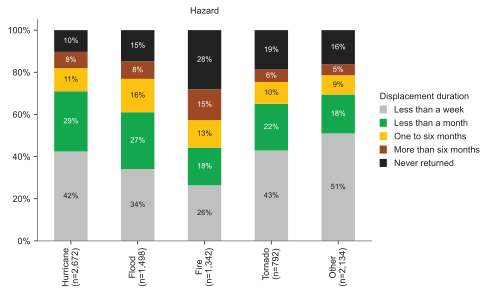

Displacement duration,Less than a week,Less than a month,One to six months,More than six months,Never returned
Hazard,,,,,
"Hurricane (n=2,672)",42.4%,28.6%,11.0%,7.7%,10.3%
"Flood (n=1,498)",34.1%,26.9%,15.8%,8.3%,14.9%
"Fire (n=1,342)",26.4%,17.9%,13.0%,14.6%,28.1%
Tornado (n=792),42.9%,22.2%,10.3%,5.9%,18.7%
"Other (n=2,134)",51.0%,18.5%,9.1%,5.1%,16.3%


In [8]:
# Check using multiple factors
main_factor = "ND_HOWLONG"
sub_factors = [f'ND_TYPE{i+1}' for i in range(5)]
n_factors = len(sub_factors)

criteria = (puf.ND_DISPLACE == 1) 

# Iterate through each factor and combine results
crossts = [create_crosstab(puf[criteria], data_dict, main_factor, curr_factor) for curr_factor in sub_factors]
crosst = pd.concat(crossts, axis=0)

# Arrange names
nd_names = [name.split(" ").pop().title() for name in data_dict.loc[sub_factors, 'Name']]
nd_names[-1] = 'Other'
nd_counts = [puf[criteria][factor].sum() for factor in sub_factors]
crosst['Hazard'] = [f'{name}\n(n={count:,.0f})' for name, count in zip(nd_names, nd_counts)]
crosst.set_index('Hazard', inplace=True)

# Plot result
bar_colors = ['silver', '#15a74e', '#fcc210', '#9e4825', '#212121']
# bar_colors = ["#efede7","#bbc493", "#8f993e","#555025", "#212121"]
fig, ax = plt.subplots()
plot_crosstab(crosst, ax, color=bar_colors)
plt.show()
fig.tight_layout()
fig.savefig(os.path.join(img_folder, "hazard_representation.png"), dpi=150, facecolor="w")

# Style dictionary
fmt_str = '{:,.1%}'
fmt_clr = 'Greens'

# Show crosstabulation
crosst.style.format(fmt_str).background_gradient(
    cmap=fmt_clr,
    axis=1,
)

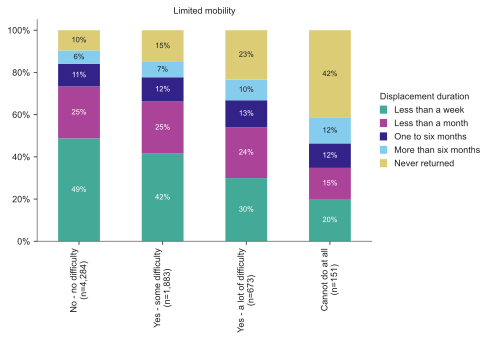

Displacement duration,Less than a week,Less than a month,One to six months,More than six months,Never returned
Limited mobility,,,,,
"No - no difficulty (n=4,284)",48.7%,24.6%,10.7%,6.4%,9.6%
"Yes - some difficulty (n=1,883)",41.5%,24.7%,11.5%,7.2%,15.1%
Yes - a lot of difficulty (n=673),30.0%,24.1%,12.7%,9.8%,23.3%
Cannot do at all (n=151),20.0%,14.7%,11.6%,12.1%,41.6%


In [9]:
# Plot an individual cross-tabulation
main_factor = "ND_HOWLONG"
curr_factor = "MOBILITY"

criteria = (puf.ND_DISPLACE == 1) 

crosst = create_crosstab(puf[criteria], data_dict, main_factor, curr_factor, samples=True)

# Plot result
fig, ax = plt.subplots()
plot_crosstab(crosst, ax)
plt.show()

# Style dictionary
fmt_str = '{:,.1%}'
fmt_clr = 'Greens'

# Preview table
crosst.style.format(fmt_str).background_gradient(
    cmap=fmt_clr,
    axis=1,
)

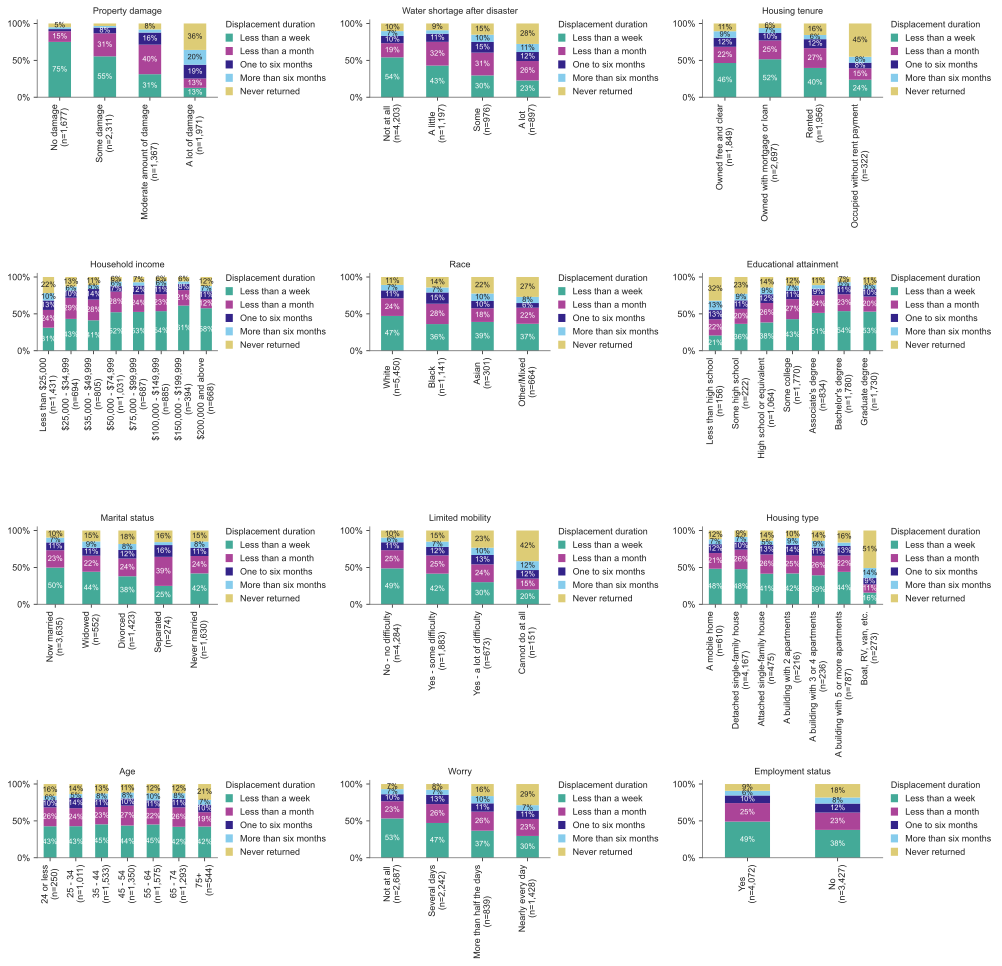

In [10]:
# Choose factors
main_factor = "ND_HOWLONG"
sub_factors = ["ND_DAMAGE", "ND_WATER", "TENURE",
               "INCOME", "RRACE", "EEDUC",
               "MS", "MOBILITY", "LIVQTRRV",
               "AGE_BIN", "WORRY", "ANYWORK"]
n_factors = len(sub_factors)

# Construct plot
xdim, ydim = int(np.ceil(n_factors/3)), 3
fig, axs = plt.subplots(xdim, ydim, figsize=(xdim*3.5, ydim*4.5))

# Filter data
criteria = (puf.ND_DISPLACE == 1) 

# Add axes
for i, ax  in zip(range(n_factors), axs.flatten()):
    curr_factor = sub_factors[i]
    crosst = create_crosstab(puf[criteria], data_dict, main_factor, curr_factor, samples=True)
    plot_crosstab(crosst, ax)
fig.tight_layout()
fig.savefig(os.path.join(img_folder, 'Trends.png'), dpi=200, facecolor='w')

# Show plot
plt.show()

## Correlation analysis

Identify factors that are highly correlated to avoid mutli-collinearity 

Nominal factors may not be calculated correctly: ['SCHOOLENROLL', 'TENURE_STATUS', 'DWELLTYPE', 'ANYWORK', 'MS', 'RMINORITY', 'HAZARD_TYPE', 'PHASE_RETURN']
These 0 columns exceed the tolerance of 60%:



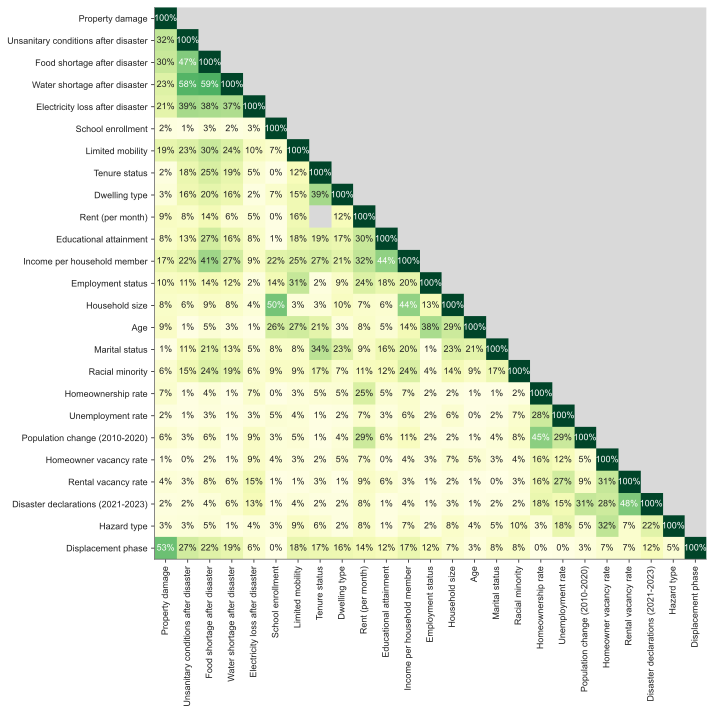

Displaying the top 15 factors correlated with PHASE_RETURN:


PHASE_RETURN           100.0%
ND_DAMAGE               52.6%
ND_UNSANITARY           27.2%
ND_FDSHRTAGE            22.4%
ND_WATER                18.6%
MOBILITY                18.0%
INCOME_PER              17.5%
TENURE_STATUS           16.6%
DWELLTYPE               16.1%
RENT_BIN                14.3%
DISASTERS_2021-2023     12.3%
ANYWORK                 11.9%
EEDUC                   11.5%
RMINORITY                8.2%
MS                       7.7%
Name: PHASE_RETURN, dtype: object

In [11]:
# Choose factors of interest
factors = [
            # 'ND_HOWLONG', 
            'ND_DAMAGE', 'ND_UNSANITARY', 'ND_FDSHRTAGE', 'ND_WATER', 'ND_ELCTRC',
            'SCHOOLENROLL', 
            # 'DOWN', 'WORRY',
            #'INTEREST', 'ANXIOUS',
            'MOBILITY', # 'REMEMBERING', 'SELFCARE', # 'UNDERSTAND', 'SEEING', 'HEARING',
            # 'TENURE', 'LIVQTRRV',
            'TENURE_STATUS', 'DWELLTYPE',
            'RENT_BIN',
            # 'TRENTAMT',
            'EEDUC', # 'INCOME', 
            'INCOME_PER', 'ANYWORK',
            # 'SETTING', 'KINDWORK', 'TWDAYS',
            'HH_BIN',
            # 'THHLD_NUMPER', 'THHLD_NUMKID', 'THHLD_NUMADLT', 'FRMLA_YN',
            'AGE_BIN','MS', 'RMINORITY', # 'GENID_DESCRIBE', 'RRACE', 'RHISPANIC',
            # 'SATISFACTION_NGBD_2021',	'SATISFACTION_HOME_2021', 
            'RATE_HOMEOWNER_2022', 'UNEMPLOYMENT_2022',
            'POPULATION_TREND_10YR', 'VACANCY_HOMEOWNER_2022', 'VACANCY_RENTAL_2022', "DISASTERS_2021-2023", # 'POPULATION_2020',
            'HAZARD_TYPE',
            'PHASE_RETURN', # 'RETURN_1', 'RETURN_2', 'PROTRACTED', 'RETURNED',
            # 'REGION'
          ]
n_factors = len(factors)

# Understand whether factors are nominal or not
remove_nominal = False
nominal_factors = [factor for factor in factors if data_dict.loc[factor, 'Type'] == 'Nominal']
print(f"Nominal factors may not be calculated correctly: {nominal_factors}")
if remove_nominal:
    print("Removing nominal factors")
    factors = [factor for factor in factors if factor not in nominal_factors]

# Filter data
criteria = (puf.ND_DISPLACE == 1) 

# Determine correlations
corr_tol = 0.6
corr_matx, upper, lower, to_drop = create_correlation_matx(puf[criteria][factors], corr_tol=corr_tol, absolute=True, method="spearman")

# Create plot 
scale = 0.4
fig, ax = plt.subplots(figsize=(scale*n_factors, scale*n_factors))
plot_correlation_matx(lower, ax, cmap='YlGn')
friendly_labels = data_dict.loc[lower.index.tolist(), 'Name'].tolist()
ax.set_xticklabels(friendly_labels)
ax.set_yticklabels(friendly_labels)
fig.tight_layout()
fig.savefig(os.path.join(img_folder, 'Correlations.png'), dpi=200, facecolor='w')

# Preview
plt.show()

# Get top correlated factors with main_factor
main_factor = 'PHASE_RETURN'
n_top = 15
print(f"Displaying the top {n_top} factors correlated with {main_factor}:")
corr_matx[main_factor].sort_values(ascending=False).head(n_top).map('{:.1%}'.format)

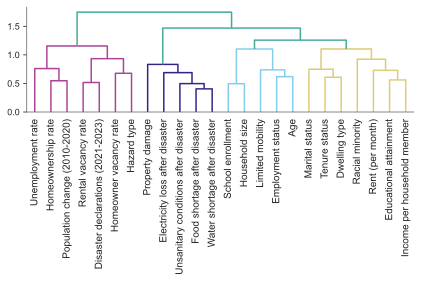

In [12]:
# Ensure the correlation matrix is symmetric
rmv = ['ND_HOWLONG', 'PHASE_RETURN', 'SELFCARE', 'REMEMBERING', 'INCOME', 'SATISFACTION_NGBD_2021', 'SATISFACTION_HOME_2021']
rmv = [col for col in rmv if col in corr_matx.columns]
cmat = corr_matx.drop(columns=rmv, index=rmv)

fig, ax = plt.subplots()
plot_heirarchical_clusters(cmat, data_dict, ax)
fig.tight_layout()
fig.savefig(os.path.join(img_folder, 'Clusters.png'), dpi=200, facecolor='w')

# Preview
plt.show()

## Determine representation of each state

In [13]:
# Choose a factor of interest
field = "EST_ST"
# Create a filter
criteria = (puf.ND_DISPLACE == 1) 

# Summarize data
field_dict = data_dict.loc[field, 'Conversion']
puf_filter = puf[criteria].copy()
puf_stats = puf_filter.groupby(field)['HWEIGHT'].agg('sum')
puf_perc = puf_stats / puf_stats.sum()
print(data_dict.loc[field, 'Name'])
puf_perc.index = puf_perc.index.astype(int).astype(str).str.zfill(2)
# puf_perc.to_csv('EST_ST_REPR.csv')
puf_perc.sort_values(ascending=False).rename(index=field_dict).map('{:.1%}'.format)

State


EST_ST
Florida                 27.4%
California              10.2%
Texas                    9.8%
Louisiana                8.6%
Michigan                 3.2%
New York                 2.9%
Georgia                  2.7%
Illinois                 2.7%
Pennsylvania             2.1%
Kentucky                 2.0%
Tennessee                1.8%
Ohio                     1.7%
North Carolina           1.6%
New Jersey               1.5%
Oklahoma                 1.3%
Missouri                 1.3%
Mississippi              1.2%
South Carolina           1.2%
Arizona                  1.2%
Colorado                 1.2%
Alabama                  1.1%
Arkansas                 1.1%
Virginia                 1.1%
Indiana                  1.1%
Oregon                   0.9%
Massachusetts            0.9%
Washington               0.9%
Maryland                 0.9%
Wisconsin                0.6%
New Mexico               0.5%
Connecticut              0.5%
Minnesota                0.5%
Nevada                   0.4%
Kan

In [14]:
# Choose factor to cross-tabulate
main_factor = "ND_DISPLACE"
curr_factor = "EST_ST"

# Ensure state codes are handled consistent with data_dict
puf.EST_ST = puf.EST_ST.astype(int).astype(str).str.zfill(2)

# Cross-tabulate
crosst = create_crosstab(puf, data_dict, main_factor, curr_factor, samples=False)

# Style dictionary
fmt_str = '{:,.1%}'
fmt_clr = 'Greens'

# Save result
# crosst.to_csv('EST_ST_DISP.csv')

# Write to variable
any_disp = crosst.rename(columns={"Yes": "DISP_ANY"})["DISP_ANY"].copy()

# Preview table
crosst.sort_values(by='Yes',ascending=False).style.format(fmt_str).background_gradient(
    cmap=fmt_clr,
    axis=1,
)

Household displacement due to disaster,Yes,No
State,,
Louisiana,9.1%,90.9%
Florida,5.9%,94.1%
Mississippi,2.0%,98.0%
Kentucky,2.0%,98.0%
Texas,1.7%,98.3%
Arkansas,1.7%,98.3%
Oklahoma,1.5%,98.5%
Michigan,1.5%,98.5%
California,1.4%,98.6%


In [15]:
# Cross-tabulate duration
main_factor = "ND_HOWLONG"
curr_factor = "EST_ST"

# Ensure state codes are handled consistent with data_dict
puf.EST_ST = puf.EST_ST.astype(int).astype(str).str.zfill(2)


# Create cross-tabulation
crosst = create_crosstab(puf, data_dict, main_factor, curr_factor, samples=False)

# Style dictionary
fmt_str = '{:,.1%}'
fmt_clr = 'Greens'

# Save result
# crosst.to_csv('EST_ST_DISP_TIME.csv')

# Calculate other variables
crosst["DISP_LT1MO"] = crosst[["Less than a week", "Less than a month"]].sum(axis=1)
crosst["DISP_GT1MO"] = crosst[["One to six months", "More than six months"]].sum(axis=1)
crosst["DISP_NORETURN"] = crosst["Never returned"]

st_dur = crosst[["DISP_LT1MO", "DISP_GT1MO", "DISP_NORETURN"]].copy()
st_data = pd.merge(any_disp, st_dur, on='State', how='left')
# st_data.to_csv("st_duration.csv")

# Preview table
st_data.style.format(fmt_str).background_gradient(
    cmap=fmt_clr,
    axis=1,
)

,DISP_ANY,DISP_LT1MO,DISP_GT1MO,DISP_NORETURN
State,,,,
Alabama,1.1%,45.8%,33.5%,20.7%
Alaska,1.3%,38.7%,23.9%,37.4%
Arizona,0.8%,52.2%,22.0%,25.8%
Arkansas,1.7%,70.9%,16.6%,12.5%
California,1.4%,68.0%,14.7%,17.4%
Colorado,0.9%,60.8%,21.9%,17.3%
Connecticut,0.7%,41.3%,44.9%,13.8%
Delaware,0.6%,68.7%,14.5%,16.8%
District of Columbia,0.6%,41.2%,38.7%,20.0%
